In [38]:
from timeit import default_timer
from pprint import PrettyPrinter
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse import load_npz, coo_matrix, csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from time import process_time
from numba import njit,jit
import datetime
from timeit import default_timer as timer

In [18]:
def gaussian_design_unconstrained(nsamples, nfeatures, variance, density=None):#, random_seed=100):
    '''
    Generate data as described in https://arxiv.org/pdf/1411.0347.pdf 3.1
    1. Generate A in R^{n \times d} with A_ij inn N(0,1)
    2. Choose x^* from S^{d-1}
    3. Set y = Ax^* + w where w ~ N(0,variance*I)
    '''
    #np.random.seed(random_seed)
    if density is not None:
        A = random(nsamples, nfeatures, density)
    else:
        A = np.random.randn(nsamples, nfeatures)
    x_true = np.random.randn(nfeatures)
    x_true /= np.linalg.norm(x_true)
    noise = np.random.normal(loc=0.0,scale=variance,size=(nsamples,))
    y = A@x_true + noise
    return A, y, x_true

# Error metrics
def mean_square_error(x1, x2):
    '''compute ||x2 - x1||_2^2'''
    return np.linalg.norm(x2-x1)**2

def prediction_error(data,x1,x2):
    '''compute np.sqrt(1/n)*||A(x1-x2)||_2'''
    return (1/data.shape[0])*np.linalg.norm(data@(x1-x2),2)**2

In [19]:
@njit(fastmath=True)
def fast_countSketch(SA,row,col,data,sign,row_map):
    N = len(data)
    for idx in range(N):
        SA[row_map[row[idx]],col[idx]]+=data[idx]*sign[row[idx]]
    return SA

def shift_bit_length(x):
    '''Given int x find next largest power of 2.
    If x is a power of 2 then x is returned '''
    return 1<<(x-1).bit_length()

class RandomProjection:
    '''
    Class based implementation of different
    Random projection methods for RNLA.
    Current examples are taken from [1]
    however there are various sampling methods
    which could also be implemented.
    [1] - https://researcher.watson.ibm.com/researcher/files/us-dpwoodru/wNow.pdf'''

    def __init__(self,data,proj_dim,
                 sketch_type,col_sparsity=1):
        '''
        data - ndarray of the data (or vector) to sketch
        proj_dim - int --> Value to sketch down to
        sketch_type - str determining which sketch to use
        Sketch Type support args:
        1. gaussian
        2. srht
        3. sjlt -- default col_sparsity is 4
        4. countsketch
        '''
        self.data = data
        self.n, self.d = data.shape
        self.proj_dim = proj_dim
        self.sketch_type = sketch_type

        # Create an attribute for dense data for later reference.
        # If data is ndarray then just make new reference, otherwise, if input
        # is sparse then make reference for dense data.
        if isinstance(self.data, np.ndarray):
            self.dense_data = self.data
        elif isinstance(self.data,sparse.coo.coo_matrix) or isinstance(self.data, sparse.csr.csr_matrix):
            #print('Converting sparse to dense data.')
            self.dense_data = self.data.toarray()

        # Convert data to sparse data for cross-comparison between sketches
        # and accept sparse inputs
        # Note that the second arg for `isinstance` depends on how the scipy
        # import is written. If it is `import scipy` then we need
        # `scipy.sparse...` but if we have `import scipy.sparse as sparse`
        # then `sparse.coo....` will suffice.

        # LOGIC: if self.data is sparse just make references for later
        # otherwise, convert to sparse data.
        if isinstance(self.data, sparse.coo.coo_matrix):
            self.coo_data = self.data
            self.rows = self.coo_data.row
            self.cols = self.coo_data.col
            self.vals = self.coo_data.data
        elif isinstance(self.data, sparse.csr.csr_matrix):
            self.coo_data = self.data.tocoo()
            self.rows = self.coo_data.row
            self.cols = self.coo_data.col
            self.vals = self.coo_data.data
        else:
            self.coo_data = coo_matrix(data)
            self.rows = self.coo_data.row
            self.cols = self.coo_data.col
            self.vals = self.coo_data.data



        if self.proj_dim > self.n:
            raise Exception(f'Sketching with projection dimension\
                             $self.proj_dim > $self.n is not supported')

        ## For SRHT do the bit shift here so not timed in call
        ## to sketch
        if self.sketch_type is 'srht':
            # preprocess data so length is correct and repeat for
            # the intermediate function after hadamard transform
            next_power2_data = shift_bit_length(self.n)
            deficit = next_power2_data - self.n
            self.dense_data = np.concatenate((self.dense_data,
                                        np.zeros((deficit,self.d),
                                        dtype=self.dense_data.dtype)), axis=0)
            # set the new n for later use although
            # sampling will only ever be from self.n
            # as the power of 2 extension only necessary for
            # the hadamard transform
            self.new_n = self.dense_data.shape[0]

        ######################## SPARSE SKETCHES ##############################


        ### For sparse sketches generate hash functions here so
        # that they aren't timed in the call to sketch.
        # Would it be better to only accept sparse datasets for the sparse
        # sketches?
        elif self.sketch_type is 'sjlt' or 'countSketch':
            self.col_sparsity = col_sparsity
            if self.sketch_type is 'sjlt' and self.col_sparsity == 1:
                self.col_sparsity = 4

        ## Function dictionary to call later on.

        self.fct_dict = {'gaussian'    : self.GaussianSketch,
                         'srht'        : self.SRHT,
                         'countSketch' : self.CountSketch,
                         'sjlt'        : self.SparseJLT}


    def GaussianSketch(self):
        '''Compute the Gaussian random transform
        S_ij = G_ij ~ N(0,1) / sqrt(proj_dim)'''
        S = np.random.randn(self.proj_dim,self.n)
        S /= np.sqrt(self.proj_dim)
        return S@self.dense_data

    def SRHT(self):
        diag = np.random.choice([1,-1], self.new_n)[:,None]
        # print("diag shape: {}".format(diag.shape))
        # print("input mat shape: {}".format(input_matrix.shape))
        signed_mat = diag*self.dense_data
        # print(signed_mat.shape)
        S = fastwht(signed_mat)*shift_bit_length(self.n) # shift bit length is normalising factor
        sample = np.random.choice(self.n, self.proj_dim, replace=False)
        #sample.sort()
        # number from num_rows_data universe
        S = S[sample]
        S = (self.proj_dim)**(-0.5)*S
        return S

    # def SRHT(self):
    #     '''
    #     Compute the Subsampled Randomized Hadamard
    #     Transform (aka Fast Johnson Lindesntrauss Transform).
    #
    #     Compute:
    #     PHDA where
    #     - DA is a diagonal matrix whose entries are
    #     {±1} chose uar
    #     - H (DA) applies the Hadamard transform on DA
    #     - P (HDA) uniformly subsamples HDA.
    #
    #
    #     Notes:
    #     The pyfht.fht_inplace doesn't seem to work so we
    #     need a little bit of working space (to store the
    #     FFTed versions of the columns) to do the
    #     entire transform'''
    #     diag = np.random.choice([1,-1], self.new_n)[:,None]
    #     signed_data = diag*self.dense_data
    #
    #     # the [:,None] syntax is just to add a 2nd dimension
    #     # so that the columns after hadamard transform can
    #     # be easily appended.
    #     # It is slightly quicker to generate lists, call
    #     # np.array, then reshape than initialising a zero
    #     # array to store the fhted columns
    #
    #     #Y = np.zeros((self.new_n,self.d))
    #     Y = []
    #     # perform the in place fht on each column
    #     for _col in range(self.d):
    #         # Y[:,_col] = pyfht.fht(self.data[:,_col])
    #         Y.append(pyfht.fht(self.dense_data[:,_col]))
    #     Y = np.array(Y)
    #     Y = Y.T
    #     #print(type(Y),Y.shape)
    #     #print(Y)
    #     # number from num_rows_data universe
    #     sample = np.random.choice(self.n, self.proj_dim, replace=False)
    #
    #     S = Y[sample] * (np.sqrt(1/(self.proj_dim)))
    #     return S

    def CountSketch(self):
        '''Compute the CountSketch transform of the data.
        This is just the  SJLT but with column sparsity 1.
        Given its own method to ensure speed is not
        implicated during later testing.'''
        self.SA = np.zeros((self.proj_dim,self.d))
        self._row_map = np.random.choice(self.proj_dim,
                                     self.n,
                                     replace=True)
        self._sign_map = np.random.choice(2, self.n, replace=True) * 2 - 1
        return fast_countSketch(self.SA,
                    self.rows,
                    self.cols,
                    self.vals,
                    self._sign_map,
                    self._row_map)

    def SparseJLT(self):
        '''Compute the SparseJLT of the data
        using the Kane-Nelson construction of
        concatenated CountSketches.
        1. Generate `s` independent countsketches
        each of size m/s x n and concatenate them.
        2. Use initial hash functions as decided above in the
        class definition and then generate new hashes for
        subsequent countsketch calls.'''
        # set the new projection dimension for sjlt
        # this is because the sjlt is an m x n sketch
        # composed of s*(m/s) x n shorter countSketches.
        self.sjlt_proj_dim = self.proj_dim // self.col_sparsity
        self.SA = np.zeros((self.sjlt_proj_dim,self.d))
        self._row_map = np.zeros((self.col_sparsity,self.n))
        self._sign_map = np.zeros((self.col_sparsity,self.n))
        # Generate array whose rows are lists for :
        # 1. row_map
        # 2. sign_map
        # Generate single array self.sjlt_proj_dim
        # to populate for the sketch to which new local
        # sketches will be added.

        for _ in range(self.col_sparsity):
            self._row_map[_,:] = np.random.choice(self.sjlt_proj_dim,
                                         self.n,
                                         replace=True)
            self._sign_map[_,:] = np.random.choice(2, self.n, replace=True) * 2 - 1
        self._row_map = self._row_map.astype(int)

        #print('size of SA ', self.SA.shape)
        #print('dType of row map ', self._row_map.dtype)
        local_row_map = self._row_map[0,:]
        local_sign_map = self._sign_map[0,:]
        global_summary = fast_countSketch(self.SA,
                    self.rows,
                    self.cols,
                    self.vals,
                    local_sign_map,
                    local_row_map)
        #print('global summary \n', global_summary)
        for sketch_id in range(1,self.col_sparsity):
            #print('sketch_id ', sketch_id+1)
            #print(self.SA)
            local_row_map = self._row_map[sketch_id,:]
            local_sign_map = self._sign_map[sketch_id,:]
            local_summary = fast_countSketch(np.zeros_like(self.SA),
                    self.rows,
                    self.cols,
                    self.vals,
                    local_sign_map,
                    local_row_map)
            global_summary = np.concatenate((global_summary,
                                             local_summary),axis=0)
        global_summary *= 1 / np.sqrt(self.col_sparsity)
        return global_summary

    def sketch(self):
        '''
        Perform the transform sketch(A) = SA
        '''
        return self.fct_dict[self.sketch_type]()

    def sketch_data_targets(self,targets):
        '''
        For classic sketching aka sketch-and-solve
        we need to sketch the matrix X where X is the
        matrix which has data|targets appended'''
        X = np.c_[self.data,targets]
        S_Ab = RandomProjection(X,self.proj_dim,self.sketch_type).sketch()
        SA = S_Ab[:,:-1]
        Sb = S_Ab[:,-1]
        #print(SA.shape, Sb.shape)
        return SA, Sb

<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:102: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:102: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-19-5e60347f8090>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.sketch_type is 'srht':
<ipython-input-19-5e60347f8090>:102: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.sketch_type is 'sjlt' or 'countSketch':
<ipython-input-19-5e60347f8090>:104: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.sketch_type is 'sjlt' and self.col_sparsity == 1:


In [28]:


class IHS:
    '''Implementation of the iterative hessian sketching scheme of
    Pilanci and Wainwright (https://arxiv.org/pdf/1411.0347.pdf)
    '''

    def __init__(self,data,targets,sketch_method,sketch_dimension,
                col_sparsity=1):

        # optimisation setup
        self.A = data
        self.b = targets

        # Need to deal with sparse type
        if isinstance(self.A, np.ndarray):
            self.ATb = self.A.T@self.b
        else:
            self.ATb = sparse.csr_matrix.dot(self.A.T,self.b)
            #self.ATb = np.squeeze(self.ATb.toarray())

        self.n, self.d = self.A.shape
        self.x = np.zeros((self.d,)) # initialise the startin point.

        self.sketch_method    = sketch_method
        self.sketch_dimension = sketch_dimension
        self.col_sparsity = col_sparsity
        # initialise the sketch to avoid the repeated costs
        self.sketcher = RandomProjection(self.A,self.sketch_dimension,
                           self.sketch_method,self.col_sparsity)
        self.coo_data = coo_matrix(data)
        self.rows = self.coo_data.row
        self.cols = self.coo_data.col
        self.vals = self.coo_data.data

    ############# OLS (VANILLA) ##########################
    def ols_fit_new_sketch(self,iterations):
            '''Solve the ordinary least squares problem iteratively using ihs
            generating a fresh sketch at every iteration.'''
            for ii in range(iterations):
                _sketch = self.sketcher.sketch()
                H = _sketch.T@_sketch
                grad_term = self.ATb - self.A.T@(self.A@self.x)
                u = np.linalg.solve(H,grad_term)
                self.x = u + self.x
            return self.x

    def ols_fit_one_sketch(self,iterations):
            '''Solve the ordinary least squares problem iteratively using ihs
            generating a fresh sketch at every iteration.
            This needs a larger sketch than if we generate a fresh sketch
            for every iteration.'''
            _sketch = self.sketcher.sketch()
            H = _sketch.T@_sketch
            for ii in range(iterations):
                grad_term = self.ATb - self.A.T@(self.A@self.x)
                u = np.linalg.solve(H,grad_term)
                self.x = u + self.x
            return self.x


    ############# OLS WITH ERROR TRACKING ##########################
    def ols_fit_new_sketch_track_errors(self,iterations):
            '''Solve the ordinary least squares problem iteratively using ihs
            generating a fresh sketch at every iteration and tracking the error
            after every iteration.
            step_size:
            '''
            self.sol_errors = np.zeros((self.d,iterations))
            for ii in range(iterations):
                _sketch = self.sketcher.sketch()
                H = _sketch.T@_sketch
                grad_term = self.ATb - self.A.T@(self.A@self.x)

                # if choose_step:
                #     eigs = np.linalg.eig(H)[0]
                #     alpha = 2.0/(eigs[0]+eigs[-1])
                # else:
                #     alpha = 1.0
                #
                #
                # grad_term *= alpha
                u = np.linalg.solve(H,grad_term)
                self.x = u + self.x
                self.sol_errors[:,ii] = self.x
            return self.x, self.sol_errors

    def ols_fit_one_sketch_track_errors(self,iterations, step_size):
            '''Solve the ordinary least squares problem iteratively using ihs
            generating a fresh sketch at every iteration.
            This needs a larger sketch than if we generate a fresh sketch
            for every iteration.
            '''
            self.sol_errors = np.zeros((self.d,iterations))
            _sketch = self.sketcher.sketch()
            H = _sketch.T@_sketch
            cov_mat = self.A.T@self.A


            # Frobenius and pointwise spectral guarantee
            _,Ss,_ = np.linalg.svd(_sketch)
            _,SigmaA,_ = np.linalg.svd(self.A)
            self.frob_error = np.linalg.norm(H - cov_mat,ord='fro') / np.linalg.norm(cov_mat,ord='fro')
            self.spectral_error = np.abs(SigmaA[0] - Ss[0])/SigmaA[0]


            #self.frob_error = np.linalg.norm(H - self.A.T@self.A,ord='fro') / np.linalg.norm(self.A.T@self.A,ord='fro')
            #self.spec_error = np.linalg.norm(H - self.A.T@self.A,ord=2) / np.linalg.norm(self.A.T@self.A,ord=2)
            # if choose_step:
            #     eigs = np.linalg.eig(H)[0]
            #     alpha = 2.0/(eigs[0]+eigs[-1])
            # else:
            #     alpha=1.0

            for ii in range(iterations):
                grad_term = step_size*(self.ATb - self.A.T@(self.A@self.x))
                u = np.linalg.solve(H,grad_term)
                self.x = u + self.x
                self.sol_errors[:,ii] = self.x
            return self.x, self.sol_errors

In [34]:

def error_vs_iterations():
    n = 6_000
    d = 200
    gamma_vals = [5,10] #[4,6,8]
    number_iterations = 20 # 40 #np.asarray(np.linspace(5,40,8), dtype=np.int)
    # Output dictionaries
    error_to_lsq = {sketch_name : {} for sketch_name in sketches}
    error_to_truth = {sketch_name : {} for sketch_name in sketches}
    for sketch_name in sketches:
        for gamma in gamma_vals:
            error_to_lsq[sketch_name][gamma] = []
            error_to_truth[sketch_name][gamma] = []
    print(error_to_lsq)
    print(error_to_truth)

    X, y, x_star = gaussian_design_unconstrained(n, d,variance=1.0)

    # Least squares estimator
    x_opt = np.linalg.lstsq(X,y)[0]
    lsq_vs_truth_errors = np.log(np.sqrt(prediction_error(X,x_opt,x_star)))

    for gamma in gamma_vals:
        sketch_size = int(gamma*d)
        print("Testing gamma: {}, num_iterations: {}".format(gamma,number_iterations))
        for sketch_method in sketches:
            #lsq_error, truth_error = 0,0
            lsq_error = np.zeros((number_iterations,))
            truth_error = np.zeros_like(lsq_error)
            if sketch_method == 'sjlt':
                col_sparsity = 4
            else:
                col_sparsity = 1

            my_ihs = IHS(X,y,sketch_method,sketch_size,col_sparsity)
            for trial in range(NTRIALS):
                print('*'*80)
                print("{}, trial: {}".format(sketch_method, trial))
                x_ihs, x_iters = my_ihs.ols_fit_new_sketch_track_errors(number_iterations)
                for _ in range(x_iters.shape[1]):
                    lsq_error[_] += prediction_error(X,x_iters[:,_], x_opt)
                    truth_error[_] += prediction_error(X,x_iters[:,_], x_star)
                print(lsq_error)
                # lsq_error += prediction_error(X,x_ihs, x_opt)
                # truth_error += prediction_error(X,x_ihs, x_star)
            mean_lsq_error = lsq_error/NTRIALS
            mean_truth_error = truth_error/NTRIALS
            print(mean_lsq_error)
            # error_to_lsq[sketch_method][gamma].append(mean_lsq_error)
            # error_to_truth[sketch_method][gamma].append(mean_truth_error)
            error_to_lsq[sketch_method][gamma] = mean_lsq_error
            error_to_truth[sketch_method][gamma] = mean_truth_error
    pretty = PrettyPrinter(indent=4)
    pretty.pprint(error_to_lsq)
    pretty.pprint(error_to_truth)
    return error_to_lsq

In [35]:
NTRIALS = 1  # NB THIS NEEDS TO BE 10 TO MATCH WITH PAPER
sketches = ['gaussian','countSketch','sjlt']


In [37]:
error2opt = error_vs_iterations()

{'gaussian': {5: [], 10: []}, 'countSketch': {5: [], 10: []}, 'sjlt': {5: [], 10: []}}
{'gaussian': {5: [], 10: []}, 'countSketch': {5: [], 10: []}, 'sjlt': {5: [], 10: []}}
Testing gamma: 5, num_iterations: 20
********************************************************************************
gaussian, trial: 0


<ipython-input-34-8619897e140e>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_opt = np.linalg.lstsq(X,y)[0]


[4.04623146e-01 1.88588913e-01 7.88673309e-02 4.92496298e-02
 2.58069551e-02 1.14675890e-02 4.12433766e-03 1.42514445e-03
 6.71618231e-04 3.73899993e-04 2.06664826e-04 9.03755377e-05
 2.81560700e-05 1.13226261e-05 5.16120808e-06 1.72150008e-06
 7.50772428e-07 2.91009610e-07 1.74351273e-07 8.46661345e-08]
[4.04623146e-01 1.88588913e-01 7.88673309e-02 4.92496298e-02
 2.58069551e-02 1.14675890e-02 4.12433766e-03 1.42514445e-03
 6.71618231e-04 3.73899993e-04 2.06664826e-04 9.03755377e-05
 2.81560700e-05 1.13226261e-05 5.16120808e-06 1.72150008e-06
 7.50772428e-07 2.91009610e-07 1.74351273e-07 8.46661345e-08]
********************************************************************************
countSketch, trial: 0
[4.25956868e-01 2.11220549e-01 8.65210089e-02 2.87703094e-02
 1.32684060e-02 5.99162485e-03 2.99433772e-03 1.47347708e-03
 6.14779564e-04 2.99768228e-04 1.63509925e-04 7.94819078e-05
 2.53726699e-05 1.44671391e-05 5.94115428e-06 3.53194674e-06
 1.52078960e-06 6.09756368e-07 2.06241706

In [42]:
error2opt

{'gaussian': {5: array([4.04623146e-01, 1.88588913e-01, 7.88673309e-02, 4.92496298e-02,
         2.58069551e-02, 1.14675890e-02, 4.12433766e-03, 1.42514445e-03,
         6.71618231e-04, 3.73899993e-04, 2.06664826e-04, 9.03755377e-05,
         2.81560700e-05, 1.13226261e-05, 5.16120808e-06, 1.72150008e-06,
         7.50772428e-07, 2.91009610e-07, 1.74351273e-07, 8.46661345e-08]),
  10: array([1.91810927e-01, 3.42793701e-02, 6.38335867e-03, 1.04428978e-03,
         1.29307755e-04, 1.92137554e-05, 2.91243303e-06, 4.84149018e-07,
         8.31223700e-08, 1.22487331e-08, 1.64567240e-09, 1.96896219e-10,
         2.67302035e-11, 2.64435087e-12, 3.82744209e-13, 5.96683414e-14,
         8.12626989e-15, 1.17712511e-15, 1.65378532e-16, 1.95237732e-17])},
 'countSketch': {5: array([4.25956868e-01, 2.11220549e-01, 8.65210089e-02, 2.87703094e-02,
         1.32684060e-02, 5.99162485e-03, 2.99433772e-03, 1.47347708e-03,
         6.14779564e-04, 2.99768228e-04, 1.63509925e-04, 7.94819078e-05,
         

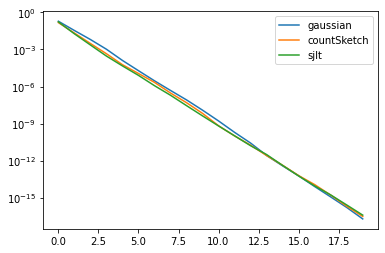

In [45]:
fig, ax = plt.subplots()
for k,v in error2opt.items():
    ax.plot(v[10],label=k)
ax.set_yscale('log')
ax.legend()